In [1]:
import matplotlib.pyplot as plt
import mne 
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from scipy.stats import spearmanr
from scipy.ndimage import gaussian_filter

from mne.stats import spatio_temporal_cluster_test, f_mway_rm, f_threshold_mway_rm, permutation_t_test
from statsmodels.stats.multitest import multipletests
from scipy.ndimage import gaussian_filter

In [2]:
path = '/home/common/bonaiuto/stop_go_bursts/derivatives/Dataset_1/'

# combine bursts_all_results and bursts_all_results_cue
bursts_all_results_laplac = np.load(f'{path}/bursts_all_results_laplac.npy', allow_pickle=True)

In [3]:
all_bursts={
    'trial': [],
    'waveform': [],
    'peak_freq': [],
    'peak_amp_iter': [],
    'peak_amp_base': [],
    'peak_time': [],
    'peak_adjustment': [],
    'fwhm_freq': [],
    'fwhm_time': [],
    'polarity': [],
    'waveform_times': [],
    'condition': [],
    'electrode': [],
    'subject': [],
    'experiment': [],
    'epochs': []
}
for bursts in bursts_all_results_laplac:
    for key in bursts:
        if not key=='waveform_times':
            all_bursts[key].extend(bursts[key])
        else:
            all_bursts[key]=bursts[key]
            
for key in all_bursts:
    all_bursts[key]=np.array(all_bursts[key])

In [4]:
c3_idx=(all_bursts['electrode']=='C3')
f4_idx=(all_bursts['electrode']=='F4')


In [5]:
# Initialize an empty list to store the mean waveforms
mean_waveforms_laplac_C3 = []

# Loop through unique subjects in the dictionary
unique_subjects = np.unique(all_bursts['subject'])
for subject in unique_subjects:
    # Extract waveforms corresponding to the current subject
    subject_waveforms = all_bursts['waveform'][c3_idx & (all_bursts['subject'] == subject),]*1e3
    
    # Calculate the mean waveform for the subject
    mean_waveform = np.mean(subject_waveforms, axis=0)
    
    # Append the mean waveform to the list
    mean_waveforms_laplac_C3.append(mean_waveform)

# Convert the list to a NumPy array
matrix_mean_waveforms_laplac_C3 = np.array(mean_waveforms_laplac_C3)


# Initialize an empty list to store the mean waveforms
mean_waveforms_laplac_F4 = []

# Loop through unique subjects in the dictionary
unique_subjects = np.unique(all_bursts['subject'])
for subject in unique_subjects:
    # Extract waveforms corresponding to the current subject
    subject_waveforms = all_bursts['waveform'][f4_idx & (all_bursts['subject'] == subject),]*1e3
    
    # Calculate the mean waveform for the subject
    mean_waveform = np.mean(subject_waveforms, axis=0)
    
    # Append the mean waveform to the list
    mean_waveforms_laplac_F4.append(mean_waveform)

# Convert the list to a NumPy array
matrix_mean_waveforms_laplac_F4 = np.array(mean_waveforms_laplac_F4)

Using a threshold of 2.200985
stat_fun(H1): min=-4.452147 max=4.348472
Running initial clustering
Found 8 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


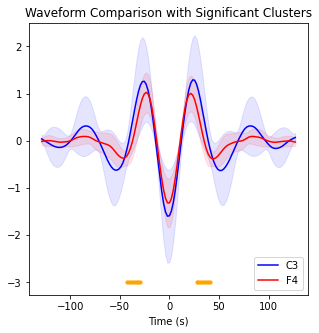

In [6]:
data = matrix_mean_waveforms_laplac_C3 - matrix_mean_waveforms_laplac_F4

# Perform cluster-based permutation test
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
    data, n_permutations=1000
)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot mean waveforms
ax.plot(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0),
    label="C3",
    color="blue",
)
ax.plot(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0),
    label="F4",
    color="red",
)

# Add shaded area using SEM around the mean waveform
ax.fill_between(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0) - np.std(matrix_mean_waveforms_laplac_C3, axis=0),
    np.mean(matrix_mean_waveforms_laplac_C3, axis=0) + np.std(matrix_mean_waveforms_laplac_C3, axis=0),
    color="blue",
    alpha=0.1,
)
ax.fill_between(
    all_bursts['waveform_times']*1e3,
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0) - np.std(matrix_mean_waveforms_laplac_F4, axis=0),
    np.mean(matrix_mean_waveforms_laplac_F4, axis=0) + np.std(matrix_mean_waveforms_laplac_F4, axis=0),
    color="red",
    alpha=0.1,
)

# Plot significant clusters as dots
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] < 0.05:
        # Add dots at the time points of the cluster
        cluster_times = all_bursts['waveform_times'][c]*1e3
        cluster_midpoint = -3  # Midpoint between the offsets for clarity
        ax.scatter(cluster_times, [cluster_midpoint] * len(cluster_times), color='orange', label='Significant Cluster' if i_c == 0 else "", s=10)

# Finalize plot

ax.set_xlabel("Time (s)")
ax.set_title("Waveform Comparison with Significant Clusters")
ax.legend(loc='lower right')
plt.show()


9 components explain 82.6841646777422% of variance


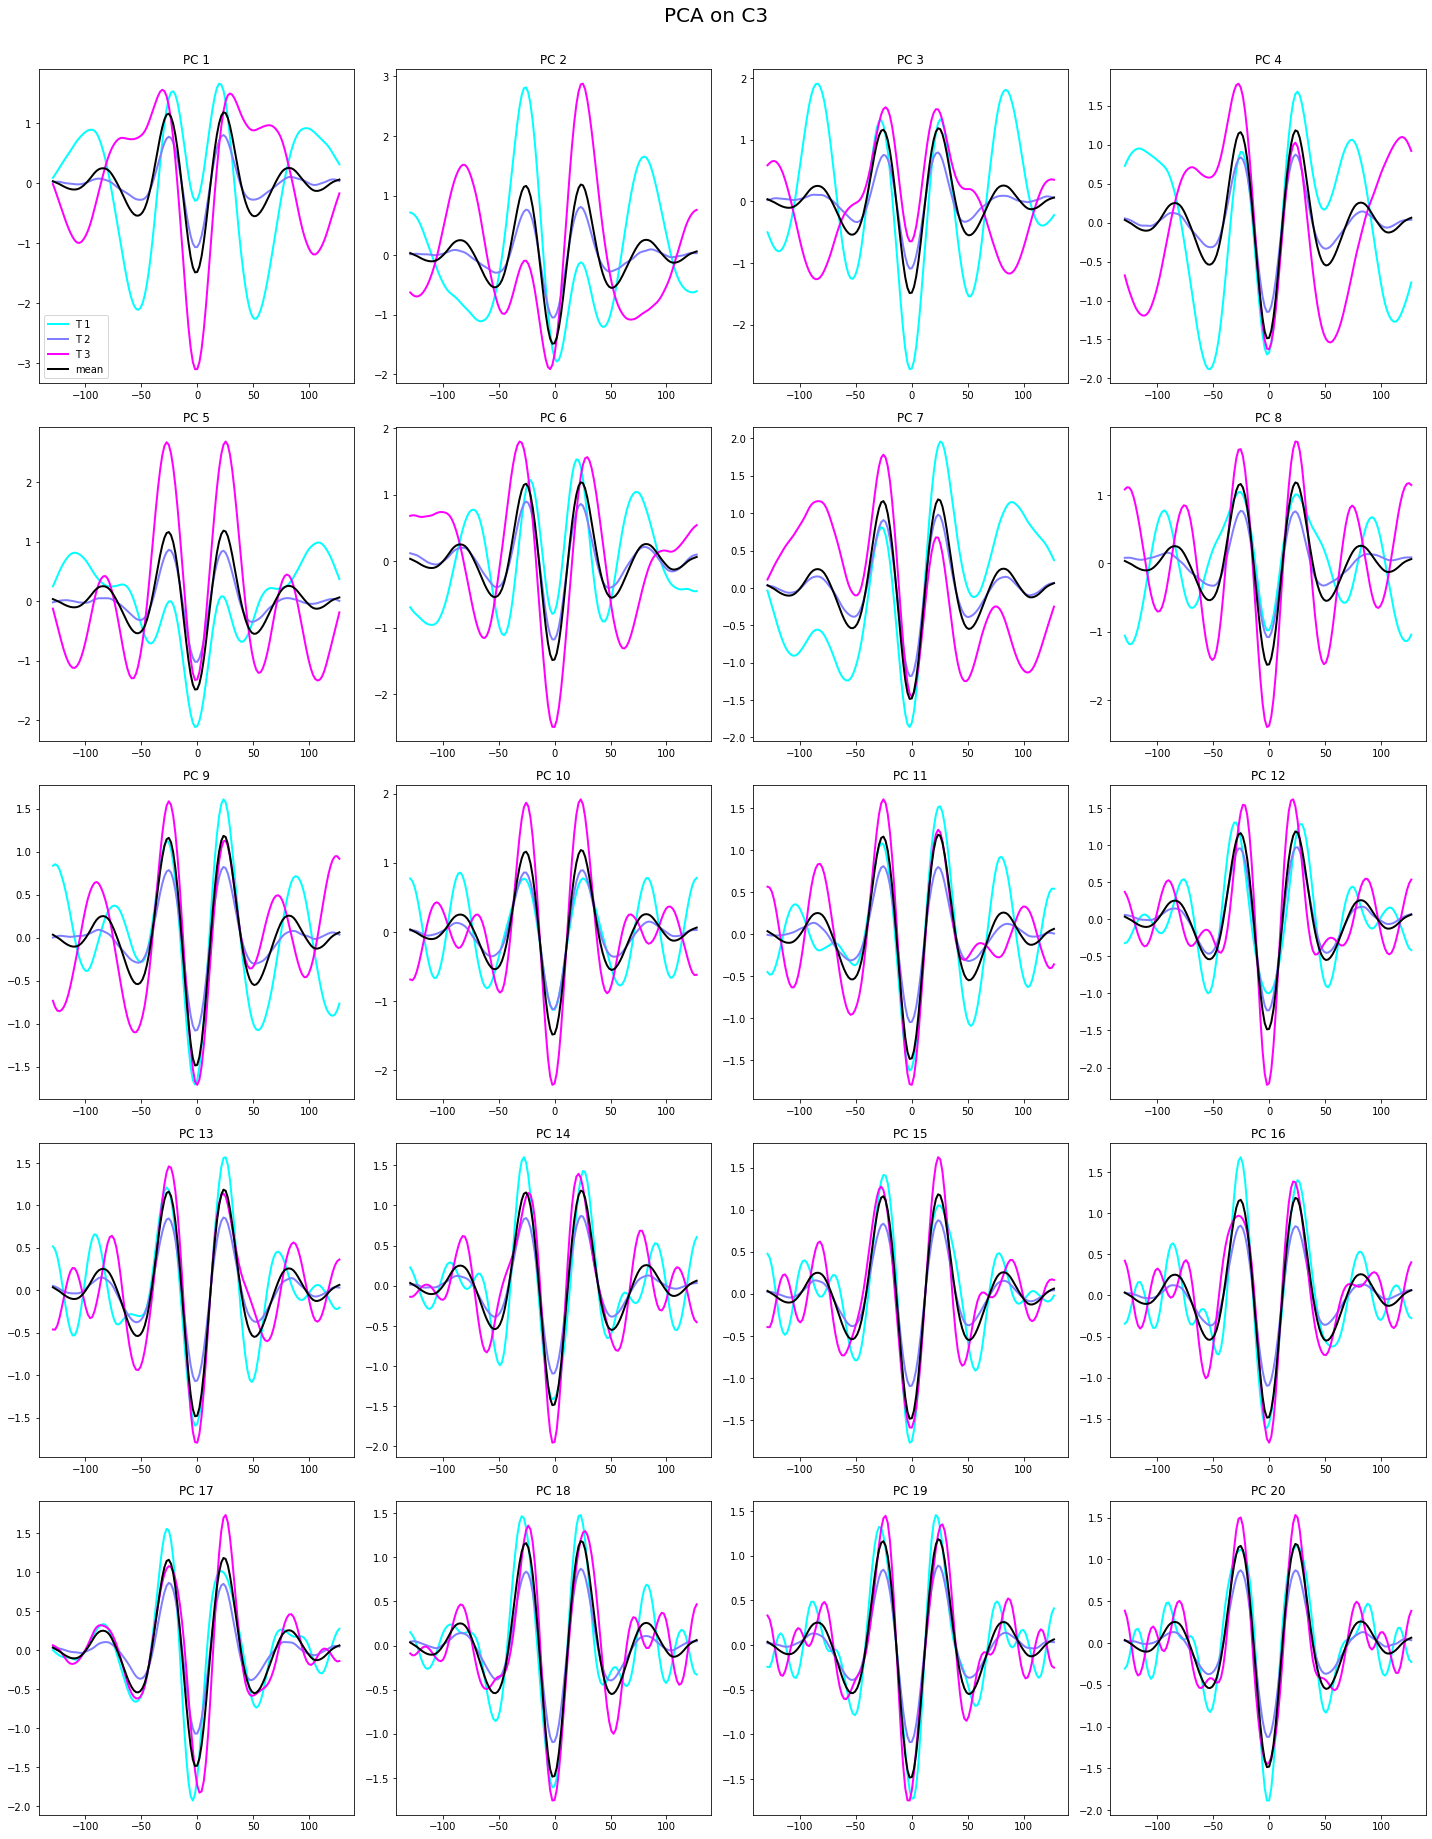

In [7]:
waveforms_laplac_C3=all_bursts['waveform'][c3_idx,:]

# Scaling and PCA on the entire dataset
model_laplac_C3 = PCA(n_components=20)
scaler_laplac_C3 = RobustScaler().fit(waveforms_laplac_C3)
waveforms_laplac_C3_std = scaler_laplac_C3.transform(waveforms_laplac_C3)
model_laplac_C3.fit(waveforms_laplac_C3_std)

cum_var_exp=np.cumsum(model_laplac_C3.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

# Transforming the data to get principal components
pc_scores_laplac_C3 = model_laplac_C3.transform(waveforms_laplac_C3_std)  # all the bursts x 20 components
pc_labels_laplac_C3 = ["PC_{}".format(i + 1) for i in range(pc_scores_laplac_C3.shape[1])]

# Quartile calculation
quartiles_laplac_C3 = np.linspace(0, 100, num=4)
quartiles_laplac_C3 = list(zip(quartiles_laplac_C3[:-1], quartiles_laplac_C3[1:]))
col_range_laplac_C3 = plt.cm.cool(np.linspace(0, 1, num=len(quartiles_laplac_C3)))
mean_waveform_laplac_C3 = np.mean(waveforms_laplac_C3, axis=0)

# Plotting the PCA results
f_laplac_C3, ax_laplac_C3 = plt.subplots(5, 4, figsize=(20, 25))
ax_laplac_C3 = ax_laplac_C3.flatten()
for pc_ix, pc in enumerate(pc_labels_laplac_C3):
    ax_laplac_C3[pc_ix].set_title(pc.replace("_", " "))  # Set the nice title
    scores_laplac_C3 = pc_scores_laplac_C3[:,pc_ix]  # Select the appropriate principal component from the dataframe
    q_maps_laplac_C3 = []
    for q_ix, (b, e) in enumerate(quartiles_laplac_C3):
        q_map_laplac_C3 = (scores_laplac_C3 > np.percentile(scores_laplac_C3, b)) & (scores_laplac_C3 <= np.percentile(scores_laplac_C3, e))  # Create a boolean map to select the waveforms_laplac_C3
        q_mean_laplac_C3 = np.mean(waveforms_laplac_C3[q_map_laplac_C3], axis=0)
        ax_laplac_C3[pc_ix].plot(all_bursts['waveform_times']*1e3, q_mean_laplac_C3*1e3, lw=2, c=col_range_laplac_C3[q_ix], label="T {}".format(q_ix + 1))
    ax_laplac_C3[pc_ix].plot(all_bursts['waveform_times']*1e3, mean_waveform_laplac_C3*1e3, lw=2, c="black", label="mean")
ax_laplac_C3[0].legend(fontsize=10)
plt.tight_layout()
plt.suptitle("PCA on C3", fontsize=20, y=1.02)
plt.show()


11 components explain 80.77816499078932% of variance


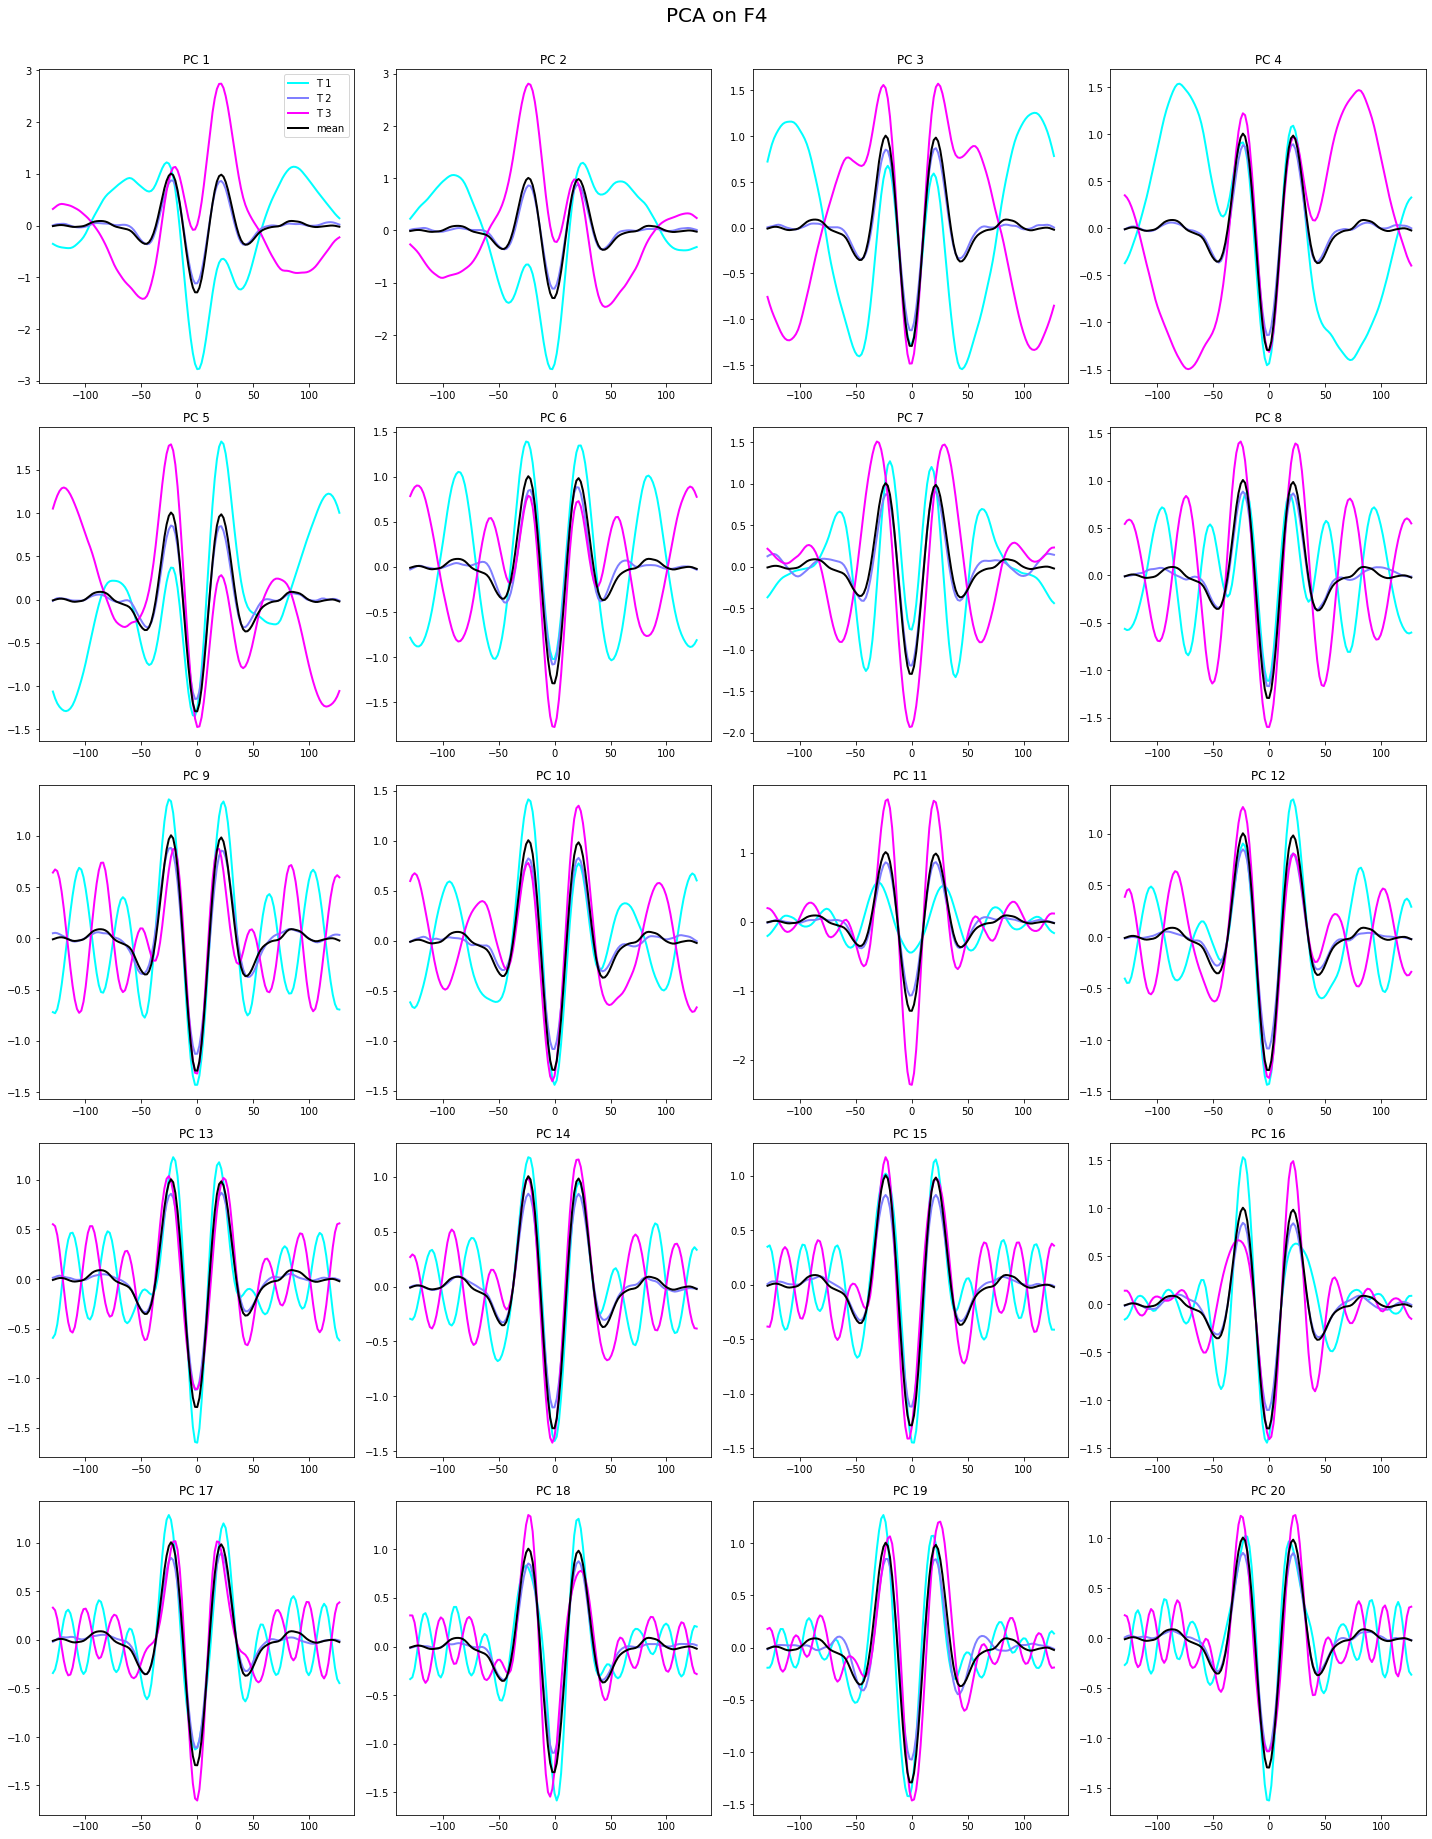

In [8]:
waveforms_laplac_F4=all_bursts['waveform'][f4_idx,:]

# Scaling and PCA on the entire dataset
model_laplac_F4 = PCA(n_components=20)
scaler_laplac_F4 = RobustScaler().fit(waveforms_laplac_F4)
waveforms_laplac_F4_std = scaler_laplac_F4.transform(waveforms_laplac_F4)
model_laplac_F4.fit(waveforms_laplac_F4_std)

cum_var_exp=np.cumsum(model_laplac_F4.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

# Transforming the data to get principal components
pc_scores_laplac_F4 = model_laplac_F4.transform(waveforms_laplac_F4_std)  # all the bursts x 20 components
pc_labels_laplac_F4 = ["PC_{}".format(i + 1) for i in range(pc_scores_laplac_F4.shape[1])]

# Quartile calculation
quartiles_laplac_F4 = np.linspace(0, 100, num=4)
quartiles_laplac_F4 = list(zip(quartiles_laplac_F4[:-1], quartiles_laplac_F4[1:]))
col_range_laplac_F4 = plt.cm.cool(np.linspace(0, 1, num=len(quartiles_laplac_F4)))
mean_waveform_laplac_F4 = np.mean(waveforms_laplac_F4, axis=0)

# Plotting the PCA results
f_laplac_F4, ax_laplac_F4 = plt.subplots(5, 4, figsize=(20, 25))
ax_laplac_F4 = ax_laplac_F4.flatten()
for pc_ix, pc in enumerate(pc_labels_laplac_F4):
    ax_laplac_F4[pc_ix].set_title(pc.replace("_", " "))  # Set the nice title
    scores_laplac_F4 = pc_scores_laplac_F4[:,pc_ix]  # Select the appropriate principal component from the dataframe
    q_maps_laplac_F4 = []
    for q_ix, (b, e) in enumerate(quartiles_laplac_F4):
        q_map_laplac_F4 = (scores_laplac_F4 > np.percentile(scores_laplac_F4, b)) & (scores_laplac_F4 <= np.percentile(scores_laplac_F4, e))  # Create a boolean map to select the waveforms_laplac_C3
        q_mean_laplac_F4 = np.mean(waveforms_laplac_F4[q_map_laplac_F4], axis=0)
        ax_laplac_F4[pc_ix].plot(all_bursts['waveform_times']*1e3, q_mean_laplac_F4*1e3, lw=2, c=col_range_laplac_F4[q_ix], label="T {}".format(q_ix + 1))
    ax_laplac_F4[pc_ix].plot(all_bursts['waveform_times']*1e3, mean_waveform_laplac_F4*1e3, lw=2, c="black", label="mean")
ax_laplac_F4[0].legend(fontsize=10)
plt.tight_layout()
plt.suptitle("PCA on F4", fontsize=20, y=1.02)
plt.show()


In [9]:
all_burst_pc_scores=np.zeros((all_bursts['waveform'].shape[0],20))
all_burst_pc_scores[c3_idx,:]=pc_scores_laplac_C3
all_burst_pc_scores[f4_idx,:]=pc_scores_laplac_F4

# model_all = PCA(n_components=20)
# all_burst_std=np.zeros((all_bursts['waveform'].shape))
# all_burst_std[c3_idx,:]=waveforms_laplac_C3_std
# all_burst_std[f4_idx,:]=waveforms_laplac_F4_std
# model_all.fit(all_burst_std)
# all_burst_pc_scores=model_all.transform(all_burst_std)

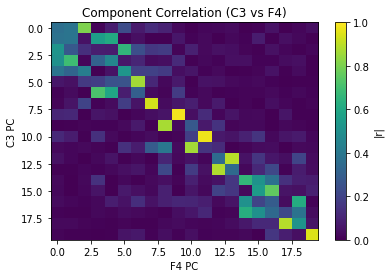

In [10]:
# Parameters
pcs_to_analyze_c = 20
min_pcs = min(model_laplac_C3.components_.shape[0], model_laplac_F4.components_.shape[0])

# Calculate the component correlation matrix
comp_corrmat_C3_F4 = np.zeros((min_pcs, min_pcs))
for i in range(min_pcs):
    for j in range(min_pcs):
        comp_corrmat_C3_F4[i, j] = np.abs(spearmanr(model_laplac_C3.components_[i, :], model_laplac_F4.components_[j, :])[0])

# Plot the correlation matrix
plt.imshow(comp_corrmat_C3_F4, aspect='auto', origin='upper', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='|r|')
plt.xlabel('F4 PC')
plt.ylabel('C3 PC')
plt.title('Component Correlation (C3 vs F4)')
plt.show()


In [11]:
# Save the fitted scaler and PCA objects
with open('robust_scaler_c3.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_laplac_C3, scaler_file)

with open('pca_object_c3.pkl', 'wb') as pca_file:
    pickle.dump(model_laplac_C3, pca_file)
    
with open('robust_scaler_f4.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_laplac_F4, scaler_file)

with open('pca_object_f4.pkl', 'wb') as pca_file:
    pickle.dump(model_laplac_F4, pca_file)

In [12]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = np.where(results > threshold)[0]
    return PCS_to_analyse

In [13]:
c3_shuffling_results=get_num_components(all_bursts['waveform'][c3_idx,:], 20)
print(f'C3 non-noise PCs: {c3_shuffling_results}')

f4_shuffling_results=get_num_components(all_bursts['waveform'][f4_idx,:], 20)
print(f'F4 non-noise PCs: {f4_shuffling_results}')

C3 non-noise PCs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
F4 non-noise PCs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [14]:
all_bursts['condition']

array(['GO', 'GO', 'GO', ..., 'FS', 'FS', 'FS'], dtype='<U2')

In [45]:
def score_var_permutation_test(pcs, b_idx):
    smth_krnl = 2.5
    n_permutations = 1000
    time_bins = np.arange(-0.25, 2, 0.02)
    bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
    n_bins = len(time_bins) - 1
    subjects = np.unique(all_bursts['subject'])

    def safe_digitize(times, bins):
        idx = np.digitize(times, bins=bins) - 1
        idx[idx < 0] = 0
        idx[idx >= n_bins] = n_bins - 1
        return idx

    subject_data = {}
    for subject in subjects:
        subj_mask = (all_bursts['subject'] == subject) & b_idx
        ss_mask = subj_mask & (all_bursts['condition'] == 'SS')
        fs_mask = subj_mask & (all_bursts['condition'] == 'FS')
        if not np.any(ss_mask) or not np.any(fs_mask):
            continue

        ss_times = all_bursts['peak_time'][ss_mask]
        ss_scores = all_burst_pc_scores[ss_mask, :]
        ss_bin_idx = safe_digitize(ss_times, time_bins)

        fs_times = all_bursts['peak_time'][fs_mask]
        fs_scores = all_burst_pc_scores[fs_mask, :]
        fs_bin_idx = safe_digitize(fs_times, time_bins)

        subject_data[subject] = {
            'ss_bin_idx': ss_bin_idx,
            'ss_scores': ss_scores,
            'fs_bin_idx': fs_bin_idx,
            'fs_scores': fs_scores
        }

    observed_mean_diff = {}
    pc_means_over_time = {'SS': {}, 'FS': {}}
    subject_bin_means_diff = {}  # To store subject-level differences for paired testing

    for pc in pcs:
        subject_bin_means = {'SS': [], 'FS': []}
        subject_bin_means_diff[pc] = []
        
        for subject in subject_data:
            ss_bin_idx = subject_data[subject]['ss_bin_idx']
            ss_scores = subject_data[subject]['ss_scores'][:, pc]
            ss_bin_sum = np.bincount(ss_bin_idx, weights=ss_scores, minlength=n_bins)
            ss_bin_count = np.bincount(ss_bin_idx, minlength=n_bins)
            ss_subj_means = np.divide(ss_bin_sum, ss_bin_count, out=np.zeros(n_bins), where=(ss_bin_count > 0))
            ss_subj_means = gaussian_filter(ss_subj_means, sigma=smth_krnl)
            subject_bin_means['SS'].append(ss_subj_means)

            fs_bin_idx = subject_data[subject]['fs_bin_idx']
            fs_scores = subject_data[subject]['fs_scores'][:, pc]
            fs_bin_sum = np.bincount(fs_bin_idx, weights=fs_scores, minlength=n_bins)
            fs_bin_count = np.bincount(fs_bin_idx, minlength=n_bins)
            fs_subj_means = np.divide(fs_bin_sum, fs_bin_count, out=np.zeros(n_bins), where=(fs_bin_count > 0))
            fs_subj_means = gaussian_filter(fs_subj_means, sigma=smth_krnl)
            subject_bin_means['FS'].append(fs_subj_means)
            
            # Calculate difference between conditions for this subject
            subj_diff = ss_subj_means - fs_subj_means
            subject_bin_means_diff[pc].append(subj_diff)

        subject_bin_means['SS'] = np.array(subject_bin_means['SS'])
        subject_bin_means['FS'] = np.array(subject_bin_means['FS'])
        subject_bin_means_diff[pc] = np.array(subject_bin_means_diff[pc])
        
        ss_mean_over_subs = np.mean(subject_bin_means['SS'], axis=0)
        fs_mean_over_subs = np.mean(subject_bin_means['FS'], axis=0)
        pc_means_over_time['SS'][pc] = ss_mean_over_subs
        pc_means_over_time['FS'][pc] = fs_mean_over_subs

        # Observed mean difference is now based on the mean of subject-level differences
        observed_mean_diff[pc] = np.sum(np.abs(np.mean(subject_bin_means_diff[pc], axis=0)))

    null_mean_diffs = {pc: [] for pc in pcs}

    for _ in range(n_permutations):
        for pc in pcs:
            # For paired test, we randomly flip the sign of the difference for each subject
            permuted_diffs = []
            
            for subj_idx, subject_diff in enumerate(subject_bin_means_diff[pc]):
                # Randomly decide whether to flip the sign for this subject
                if np.random.rand() < 0.5:
                    permuted_diffs.append(-subject_diff)  # Flip the sign
                else:
                    permuted_diffs.append(subject_diff)   # Keep original sign
            
            permuted_diffs = np.array(permuted_diffs)
            mean_permuted_diff = np.mean(permuted_diffs, axis=0)
            null_mean_diffs[pc].append(np.sum(np.abs(mean_permuted_diff)))

    p_vals = {pc: (np.sum(np.array(null_mean_diffs[pc]) >= observed_mean_diff[pc]) + 1) / (n_permutations + 1) for pc in observed_mean_diff}
    significant_pcs = [pc for pc in pcs if p_vals[pc] < 0.05]  # Bonferroni correction

    print(f"Significant PCs: {significant_pcs}")
    
    # Optional: Print p-values for each PC
    for pc in pcs:
        print(f"PC {pc+1}: p-value = {p_vals[pc]:.4f}" + (" *" if pc in significant_pcs else ""))

    num_pcs = len(pcs)
    num_rows = int(np.ceil(num_pcs / 4))
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axs = axs.flatten()

    for i, pc in enumerate(pcs):
        ax = axs[i]
        ss_bin_means = pc_means_over_time['SS'][pc]
        fs_bin_means = pc_means_over_time['FS'][pc]

        ax.plot(bin_centers, ss_bin_means, label='SS')
        ax.plot(bin_centers, fs_bin_means, label='FS')
        ax.legend()
        ax.set_xlim(bin_centers[0], bin_centers[-1])
        color = 'red' if pc in significant_pcs else 'black'
        ax.set_title(f"PC {pc + 1}" + (" *" if pc in significant_pcs else ""), color=color)

        if i % 4 == 0:
            ax.set_ylabel("Mean Score")
        if i >= (num_pcs - 4):
            ax.set_xlabel("Time (s)")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    return observed_mean_diff, null_mean_diffs, significant_pcs

Significant PCs: [2, 4]
PC 1: p-value = 0.9171
PC 2: p-value = 0.3057
PC 3: p-value = 0.0260 *
PC 4: p-value = 0.5794
PC 5: p-value = 0.0040 *
PC 6: p-value = 0.8442
PC 7: p-value = 0.5135
PC 8: p-value = 0.1149
PC 9: p-value = 0.2777
PC 10: p-value = 0.8062
PC 11: p-value = 0.1189
PC 12: p-value = 0.0539
PC 13: p-value = 0.4466
PC 14: p-value = 0.5105


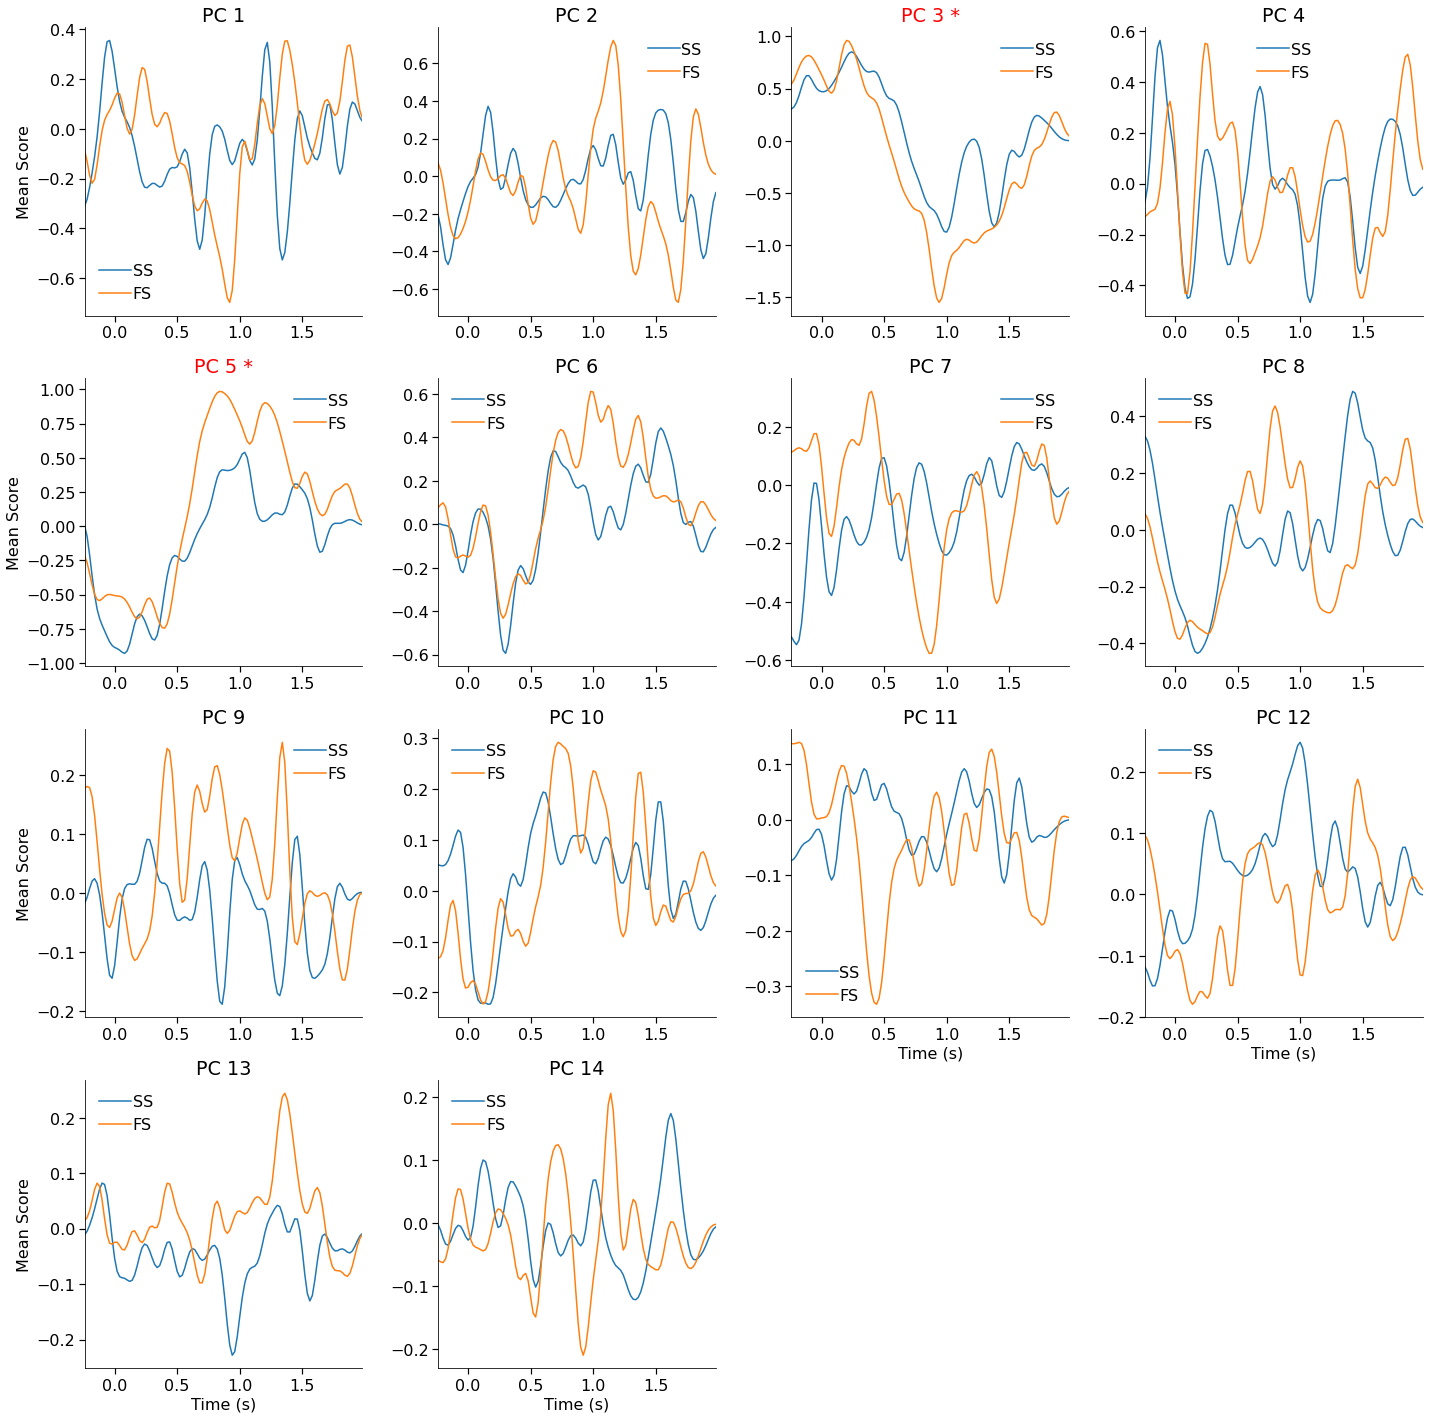

In [46]:
observed_mean_diff_c3, null_mean_diffs_c3, significant_pcs_c3 = score_var_permutation_test(c3_shuffling_results, c3_idx)
#observed_variance_c3, null_variances_c3, significant_pcs_c3 = temporal_variance_permutation_test(c3_shuffling_results, c3_idx)

Significant PCs: [5, 10]
PC 1: p-value = 0.6154
PC 2: p-value = 0.1229
PC 3: p-value = 0.3307
PC 4: p-value = 0.6144
PC 5: p-value = 0.5105
PC 6: p-value = 0.0100 *
PC 7: p-value = 0.2498
PC 8: p-value = 0.4006
PC 9: p-value = 0.2517
PC 10: p-value = 0.1369
PC 11: p-value = 0.0310 *
PC 12: p-value = 0.8302
PC 13: p-value = 0.5165
PC 14: p-value = 0.1269
PC 15: p-value = 0.4625
PC 16: p-value = 0.4416
PC 17: p-value = 0.2078


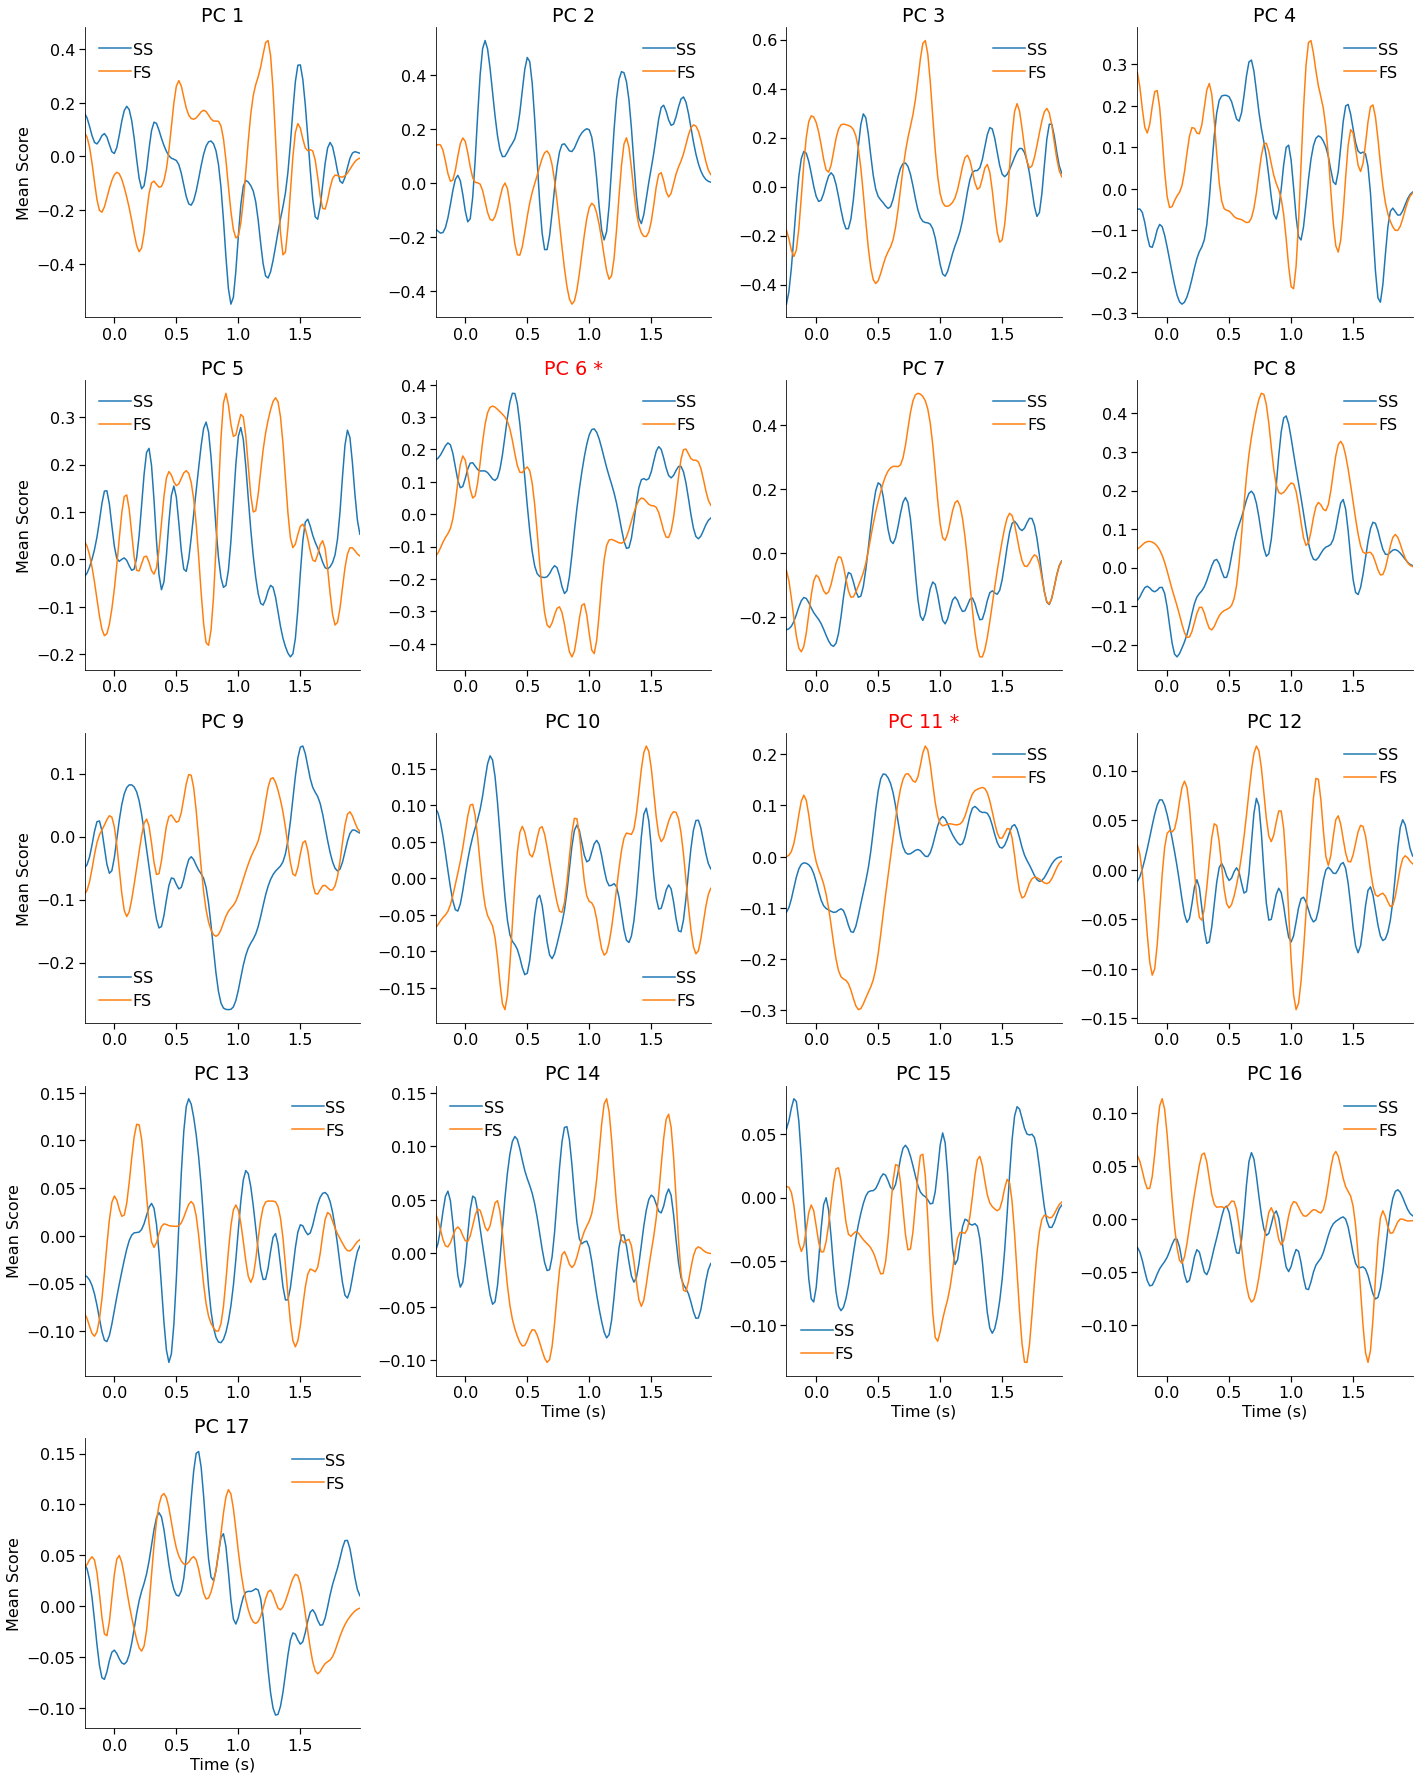

In [47]:
observed_mean_diff_f4, null_mean_diffs_f4, significant_pcs_f4 = score_var_permutation_test(f4_shuffling_results, f4_idx)
#observed_variance_f4, null_variances_f4, significant_pcs_f4 = temporal_variance_permutation_test(f4_shuffling_results, f4_idx)

Text(0, 0.5, 'Variance of the mean')

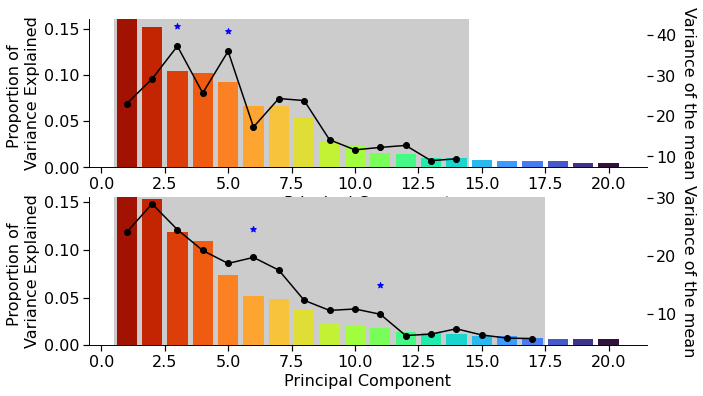

In [48]:
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(2, 1, 1)
PC_var_exp = model_laplac_C3.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
shuf_plot=np.zeros(PC_var_exp.shape[0])
shuf_plot[c3_shuffling_results]=np.max(PC_var_exp)
bar = ax.bar(PC_r, shuf_plot, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_ylim([0, PC_var_exp[0]])
ax2 = ax.twinx()
ax2.scatter(c3_shuffling_results+1, [observed_mean_diff_c3[x] for x in c3_shuffling_results], color='k')
ax2.plot(c3_shuffling_results+1, [observed_mean_diff_c3[x] for x in c3_shuffling_results], color='k')
ax2.scatter(np.array(significant_pcs_c3)+1, [observed_mean_diff_c3[x]+5 for x in significant_pcs_c3],marker='*',color='b')
ax2.set_ylabel("Variance of the mean", rotation=-90, labelpad=20)

ax = plt.subplot(2, 1, 2)
PC_var_exp = model_laplac_F4.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
shuf_plot=np.zeros(PC_var_exp.shape[0])
shuf_plot[f4_shuffling_results]=np.max(PC_var_exp)
bar = ax.bar(PC_r, shuf_plot, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_ylim([0, PC_var_exp[0]])
ax2 = ax.twinx()
ax2.scatter(f4_shuffling_results+1, [observed_mean_diff_f4[x] for x in f4_shuffling_results], color='k')
ax2.plot(f4_shuffling_results+1, [observed_mean_diff_f4[x] for x in f4_shuffling_results], color='k')
ax2.scatter(np.array(significant_pcs_f4)+1, [observed_mean_diff_f4[x]+5 for x in significant_pcs_f4],marker='*',color='b')
ax2.set_ylabel("Variance of the mean", rotation=-90, labelpad=20)


In [52]:
def stat_fun(*args):
    return f_mway_rm(
        np.swapaxes(args, 0, 0),
        factor_levels=[3],
        effects='A',
        return_pvals=False,
    )[0]

def plot_pc_burst_rate(pc_idx, b_idx):
    n_q = 4
    step = 100 / n_q
    q_bins = np.percentile(all_burst_pc_scores[:, pc_idx], np.arange(0, 100 + step, step))

    time_bin_size = 0.02
    time_bins = np.arange(-1, 2 + time_bin_size, time_bin_size)

    q_rates_smoothed = {q: {'FS': [], 'SS': [], 'GO': []} for q in range(n_q)}
    subjects=np.unique(all_bursts['subject'])

    # Calculate smoothed burst rates by quantile x condition x subject
    for subject in subjects:
        subj_idx = b_idx & (all_bursts['subject'] == subject)
        for q in range(n_q):
            q_idx = ((all_burst_pc_scores[:, pc_idx] >= q_bins[q]) &
                     (all_burst_pc_scores[:, pc_idx] <= q_bins[q+1]))
            for cond in ['FS', 'SS', 'GO']:
                cond_trials = np.unique(
                    all_bursts['trial'][subj_idx & (all_bursts['condition'] == cond)]
                )
                unsmoothed_rate, _ = np.histogram(
                    all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == cond) & q_idx],
                    bins=time_bins
                )
                # Convert to rate
                unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                smoothed_rate = gaussian_filter(unsmoothed_rate, sigma=2)
                base_idx = np.where((time_bins >= -0.6) & (time_bins < -0.1))[0]
                base_rate = np.mean(smoothed_rate[base_idx])
                smoothed_rate = smoothed_rate - base_rate

                q_rates_smoothed[q][cond].append(smoothed_rate)

    # Truncate last bin
    time_bins = time_bins[:-1]
    idx = np.where((time_bins >= -0.6) & (time_bins <= 1.6))[0]
    time_bins = time_bins[idx]

    # Convert each quantile+condition?s list of arrays to np arrays
    for q in range(n_q):
        for cond in ['FS', 'SS', 'GO']:
            q_rates_smoothed[q][cond] = np.vstack(q_rates_smoothed[q][cond])[:, idx]

    plt.figure(figsize=(6*n_q, 3))
    plt.rcParams.update({
        'font.size': 16,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.major.size': 6,
        'xtick.major.width': 1.2,
        'ytick.major.size': 6,
        'ytick.major.width': 1.2,
        'legend.frameon': False,
        'legend.handletextpad': 0.1,
        'svg.fonttype': 'none',
        'text.usetex': False
    })

    # For each quantile, do a 1x3 repeated-measures ANOVA across time
    for q in range(n_q):
        ax = plt.subplot(1, n_q, q + 1)

        # Plot grand averages for each condition
        for cond in ['FS', 'SS', 'GO']:
            mean_rate = np.mean(q_rates_smoothed[q][cond], axis=0)
            sem_rate = np.std(q_rates_smoothed[q][cond], axis=0) / np.sqrt(q_rates_smoothed[q][cond].shape[0])
            ax.plot(time_bins, mean_rate, label=cond)
            ax.fill_between(time_bins, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.2)

        # X shape: (n_subjects, n_conditions, n_times)
#         X = np.stack((
#             q_rates_smoothed[q]['FS'],
#             q_rates_smoothed[q]['SS'],
#             q_rates_smoothed[q]['GO']
#         ), axis=1)
        
#         # For a one-way repeated-measures ANOVA with 3 levels, define factor_levels=[3].
#         # We will test effect 'A' (the only factor).
#         factor_levels = [3]
#         effects = 'A'  # Single factor

#         # Compute threshold for cluster test
#         threshold = f_threshold_mway_rm(
#             n_subjects=X.shape[0],
#             factor_levels=factor_levels,
#             effects=effects
#         )

#         # Run cluster-based permutation on F-stat
#         f_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_test(
#             X,
#             threshold=threshold,
#             stat_fun=stat_fun,
#             n_permutations=50000,
#             tail=1.0,
#             n_jobs=-1
#         )
        #print((q_rates_smoothed[q]['FS']-q_rates_smoothed[q]['SS']).shape)
        T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
            q_rates_smoothed[q]['SS']-q_rates_smoothed[q]['FS'], n_permutations=5000, tail=0
        )
#         print(T_obs)
#         print(clusters)
#         print(cluster_p_values)
#         print(H0)


        # Mark significant cluster spans
        for (c_inds,), p_val in zip(clusters, cluster_p_values):
            if p_val < 0.05:  # cluster-level alpha
                # c_inds is a slice or range of time indices
                ax.axvspan(
                    time_bins[c_inds[0]], 
                    time_bins[c_inds[-1]],
                    color='yellow', alpha=0.2
                )

        ax.set_xlabel("Task time (s)")
        if q==0:
            ax.set_ylabel("Burst rate")
            plt.legend()

    plt.tight_layout()

Using a threshold of 2.200985
stat_fun(H1): min=-2.598210 max=1.775205
Running initial clustering
Found 4 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.019719 max=2.526972
Running initial clustering
Found 2 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.512944 max=1.930371
Running initial clustering
Found 1 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-3.003563 max=4.325745
Running initial clustering
Found 4 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.039715 max=4.246852
Running initial clustering
Found 3 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-1.701095 max=2.214765
Running initial clustering
Found 1 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.447848 max=1.388511
Running initial clustering
Found 1 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-4.524140 max=1.875148
Running initial clustering
Found 2 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


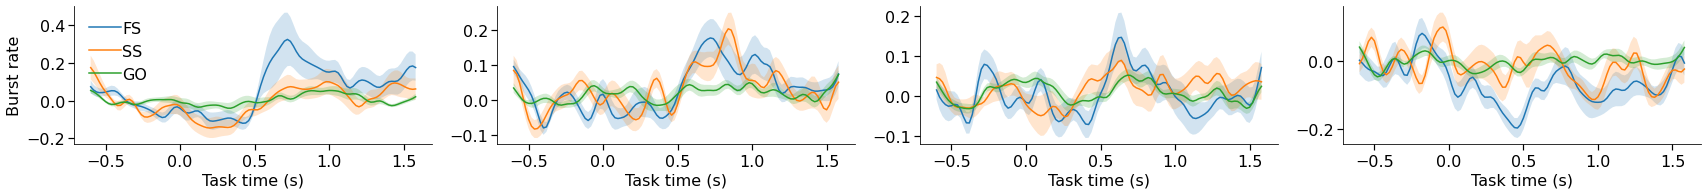

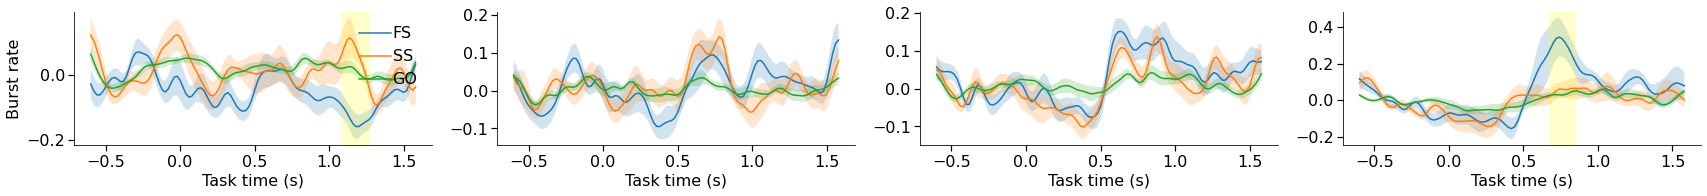

In [53]:
for pc_idx in significant_pcs_c3:
#for pc_idx in c3_shuffling_results:
    plot_pc_burst_rate(pc_idx, c3_idx)

Using a threshold of 2.200985
stat_fun(H1): min=-3.437956 max=2.577493
Running initial clustering
Found 4 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-1.876870 max=2.193039
Running initial clustering
Found 0 clusters
Using a threshold of 2.200985
stat_fun(H1): min=-1.598630 max=1.699076
Running initial clustering
Found 0 clusters
Using a threshold of 2.200985
stat_fun(H1): min=-1.963528 max=2.961804
Running initial clustering
Found 2 clusters
Permuting 2047 times (exact test)...


/home/bonaiuto/tmp/ipykernel_2506/2360344289.py:109: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
/home/bonaiuto/tmp/ipykernel_2506/2360344289.py:109: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.279672 max=2.034505
Running initial clustering
Found 1 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.632824 max=1.159516
Running initial clustering
Found 1 clusters
Permuting 2047 times (exact test)...


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Using a threshold of 2.200985
stat_fun(H1): min=-2.085856 max=1.962951
Running initial clustering
Found 0 clusters
Using a threshold of 2.200985
stat_fun(H1): min=-1.635450 max=3.203213
Running initial clustering
Found 3 clusters
Permuting 2047 times (exact test)...


/home/bonaiuto/tmp/ipykernel_2506/2360344289.py:109: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


  0%|          |  : 0/2047 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


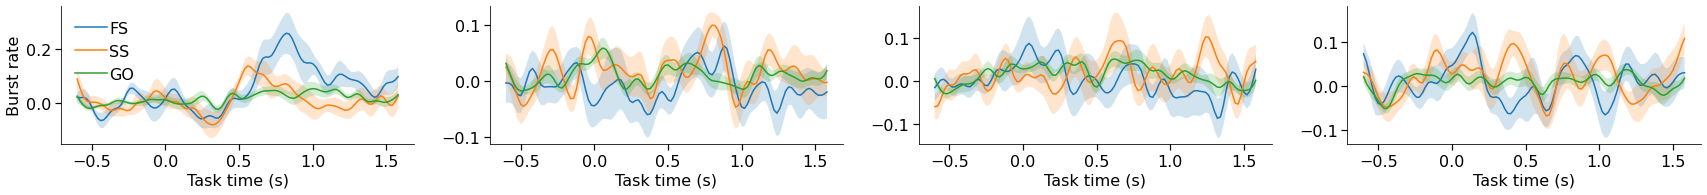

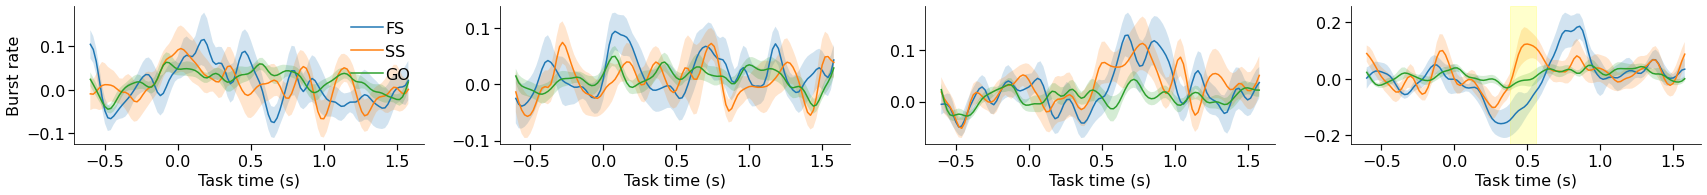

In [54]:
for pc_idx in significant_pcs_f4:
#for pc_idx in f4_shuffling_results:
    plot_pc_burst_rate(pc_idx, f4_idx)